# Plot classification performace (step 3)

In [1]:
import dask.dataframe as ddf
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy import stats
from sklearn.metrics import confusion_matrix

from Metrics import ir_metrics

BASE_PATH = "/Users/erotundo/PycharmProjects/DatasetAnnotatorProj/Analysis/Data/travel/"
PRED_PATH = BASE_PATH + "predictions_threads_acceptedOnly_ansCountGte2_binaryBestAnswer/"


# plotting settings
sns.set(style="white", palette="muted", color_codes=True)
PLOTS_PATH = 'output/travel/'
PLOTS_FORMATS = ['.pdf', '.png']

## Helper functions for computing metrics

In [2]:
def dcg_at_k(df, k, col):
    """
    Input: whole DF of all predictions
    Returns: array with a metric for each thread in DF
    """
    metrics = []
    for name, group in df.groupby(by='thread_id'):
        group = group.sort_values('y_true', ascending=False)
        metrics.append(ir_metrics.dcg_at_k(group[col], k, method=1))
    return metrics

def mrr(df, col):
    """
    Input: whole DF of all predictions
    Returns: float, a metric for the whole DF!
    """
    ranks = []
    for name, group in df.groupby(by='thread_id'):
        group = group.sort_values('y_true', ascending=False)
        ranks.append(group[col].values)
    return ir_metrics.mean_reciprocal_rank(ranks)

def precision_at_k(df, k, col):
    """
    Input: whole DF of all predictions
    Returns: array with a metric for each thread in DF
    """
    metrics = []
    for name, group in df.groupby(by='thread_id'):
        group = group.sort_values('y_true', ascending=False)
        try:
            metrics.append(ir_metrics.precision_at_k(group[col], k))
        except:
            pass
    return metrics

    
def add_random_predictions(df):
    """
    Input: whole DF of all predictions
    Returns: DF with +1 column for random predictions
    """
    df_ = df.copy(deep=True)
    rnd_preds_all = []
    for name, group in df.groupby(by='thread_id'):
        # set all preds to class-0
        rnd_preds = np.random.randint(1, size=group.shape[0])
        # randomly swap a prediction to class-1
        position_for_1 = np.random.randint(group.shape[0], size=1)
        #rnd_preds[position_for_1] = 1.0
        rnd_preds[position_for_1] = np.random.randint(2, size=1)[0]
        rnd_preds_all.extend(rnd_preds)
    df_['y_pred_rnd'] = rnd_preds_all
    return df_

## Compute metrics

In [3]:
mean_dcg_data = dict()
mean_mrr_data = dict()
mean_precision_data = dict()

# post
mean_dcg_data_post = dict()
mean_mrr_data_post = dict()
mean_precision_data_post = dict()

std_dcg_data = dict()
std_precision_data = dict()

confusion_matrix_dict = dict()

files = ['AdaBoostClassifier',
         'KNeighborsClassifier',
         'LogisticRegression',
         'MLPClassifier',
         'RandomForestClassifier',
         'SVC']

files = ['Random', 'RandomForestClassifier', 'LogisticRegression', 'SVC', 'KNeighborsClassifier']

for file_name in files:
    model_name = file_name
    print model_name,
    
    # init
    mean_dcg_data[model_name] = []
    mean_mrr_data[model_name] = []
    mean_precision_data[model_name] = []
    mean_dcg_data_post[model_name] = []
    mean_mrr_data_post[model_name] = []
    mean_precision_data_post[model_name] = []
    std_dcg_data[model_name] = []
    std_precision_data[model_name] = []

    
    if file_name is not 'Random':
        # read predictions
        df_model = pd.read_csv(PRED_PATH + file_name + "_predictions.csv")\
            .drop('Unnamed: 1', axis=1)\
            .drop('thread_id.1', axis=1)\
            .drop('pred_proba_class0', axis=1)\
            .drop('pred_proba_class1', axis=1)\
            .drop('rnd_pred', axis=1)\
            .drop('post_id', axis=1)    
    else:
        # generate random predictions
        df_model = add_random_predictions(pd.read_csv(PRED_PATH + "RandomForestClassifier_predictions.csv")\
            .drop('Unnamed: 1', axis=1)\
            .drop('thread_id.1', axis=1)\
            .drop('pred_proba_class0', axis=1)\
            .drop('pred_proba_class1', axis=1)\
            .drop('rnd_pred', axis=1)\
            .drop('post_id', axis=1))
        
        print df_model
    
    confusion_matrix_dict[model_name] = confusion_matrix(y_true=df_model['y_true'], y_pred=df_model['y_pred'])
    
    # compute metrics for different k
    for k in xrange(1, 11):
        print k,
        if file_name is not 'Random':
            col = 'y_pred'
        else:
            col = 'y_pred_rnd'
            
        mean_dcg_data[model_name].append(np.mean(dcg_at_k(df_model, k, col)))
        mean_mrr_data[model_name].append(mrr(df_model, col))
        mean_precision_data[model_name].append(np.mean(precision_at_k(df_model, k, col)))
        
        mean_dcg_data_post[model_name].append(np.mean(dcg_at_k(df_model, k, 'y_pred_post')))
        mean_mrr_data_post[model_name].append(mrr(df_model, 'y_pred_post'))
        mean_precision_data_post[model_name].append(np.mean(precision_at_k(df_model, k, 'y_pred_post')))
        
        std_dcg_data[model_name].append(np.std(dcg_at_k(df_model, k, col)) / np.sqrt(df_model.shape[0]))
        std_precision_data[model_name].append(np.std(precision_at_k(df_model, k, col)) / np.sqrt(df_model.shape[0]))

Random       thread_id  y_pred  y_true  y_pred_post  y_pred_rnd
0          25.0     1.0     1.0          1.0           0
1          25.0     1.0     0.0          0.0           0
2          25.0     0.0     0.0          0.0           0
3          25.0     0.0     0.0          0.0           0
4          25.0     0.0     0.0          0.0           0
5          25.0     0.0     0.0          0.0           0
6          25.0     0.0     0.0          0.0           0
7          25.0     0.0     0.0          0.0           0
8          28.0     0.0     0.0          1.0           0
9          28.0     0.0     1.0          0.0           0
10         28.0     0.0     0.0          0.0           1
11         73.0     1.0     0.0          1.0           0
12         73.0     0.0     1.0          0.0           0
13         73.0     0.0     0.0          0.0           0
14         73.0     0.0     0.0          0.0           1
15         73.0     0.0     0.0          0.0           0
16         77.0     0.0 

In [4]:
markers = ['o', 'X', '+', 'v', 's', '^']
marker = dict()
for file_name, m in zip(files, markers):
    marker[file_name] = m

In [5]:
mean_dcg_data['Random']

[0.20689655172413793,
 0.3316747484243755,
 0.35855101617285423,
 0.36510289078857516,
 0.36745696466627015,
 0.36926328914450562,
 0.37061555418845415,
 0.37093549828255734,
 0.37185141104826924,
 0.37214458024331781]

In [6]:
mean_dcg_data['RandomForestClassifier']

[0.46044624746450302,
 0.59994187249348663,
 0.61667615241235063,
 0.62279123538702363,
 0.62436061797215359,
 0.62616694245038895,
 0.62751920749433776,
 0.6284790397766471,
 0.62878434403188443,
 0.62995702081207861]

In [7]:
mean_dcg_data_post['RandomForestClassifier']

[0.7079107505070994,
 0.89219854871052717,
 0.89219854871052717,
 0.89219854871052717,
 0.89219854871052717,
 0.89219854871052717,
 0.89219854871052717,
 0.89219854871052717,
 0.89219854871052717,
 0.89219854871052717]

## Time for plotting...

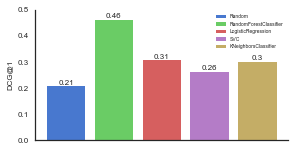

In [9]:
# plot DCG@1 bars

fig = plt.figure(figsize=(4, 2))
ax1 = fig.add_subplot(111)

labels = []
for idx, file_name in enumerate(files):
    labels.append(mean_dcg_data[file_name][0])
    rect = ax1.bar(idx,  
            mean_dcg_data[file_name][0],  
            label=file_name)
    
rects = ax1.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height + height*0.01, 
             np.round(label, decimals=2), 
             ha='center', 
             va='bottom',
            fontsize=8)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylim([0.0, 0.5])

plt.ylabel('DCG@1', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='x', bottom='off', labelbottom='off')

plt.grid(alpha=0.0, linestyle='dotted')
plt.legend(fontsize=5)
plt.tight_layout(pad=0.3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'dcg1_bars' + plot_format)

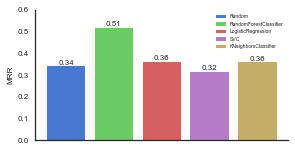

In [320]:
# plot MRR bars

fig = plt.figure(figsize=(4, 2))
ax1 = fig.add_subplot(111)

labels=[]
for idx, file_name in enumerate(files):
    labels.append(mean_mrr_data[file_name][0])
    ax1.bar(idx, 
             mean_mrr_data[file_name][0], 
             label=file_name)

rects = ax1.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height + height*0.01, 
             np.round(label, decimals=2), 
             ha='center', 
             va='bottom',
            fontsize=8)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylim([0.0, 0.6])

plt.ylabel('MRR', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='x', bottom='off', labelbottom='off')

plt.grid(alpha=0.0, linestyle='dotted')
plt.legend(fontsize=5)
plt.tight_layout(pad=0.3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'mrr_bars' + plot_format)

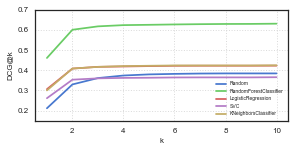

In [334]:
# plot NDCG curves

fig = plt.figure(figsize=(4, 2))
ax1 = fig.add_subplot(111)


for model_name in files:
    ax1.plot(range(1, 11), 
             mean_dcg_data[model_name], 
             label=model_name)
ax1.set_ylim([0.15, 0.7])

plt.xlabel('k', fontsize=8)
plt.ylabel('DCG@k', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)

plt.grid(alpha=0.7, linestyle='dotted')
plt.legend(fontsize=5)
plt.tight_layout(pad=0.3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'dcgK_lines' + plot_format)

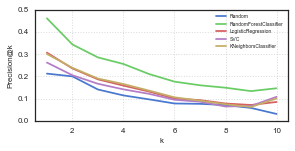

In [318]:
# plot P@1 curves

fig = plt.figure(figsize=(4, 2))
ax1 = fig.add_subplot(111)

for model_name in files:
    ax1.plot(range(1,11), 
             mean_precision_data[model_name], 
             label=model_name)
ax1.set_ylim([0.0, 0.5])

plt.xlabel('k', fontsize=8)
plt.ylabel('Precision@k', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)

plt.grid(alpha=0.7, linestyle='dotted')
plt.legend(fontsize=5)
plt.tight_layout(pad=0.3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'precision_lines' + plot_format)

## Feature importances (RF)

In [3]:
from sklearn.externals import joblib
rf_path = '/Users/erotundo/PycharmProjects/DatasetAnnotatorProj/Analysis/Data/travel/' + \
'pickled_threads_acceptedOnly_ansCountGte2_binaryBestAnswer/' + \
'RandomForestClassifier_sklearn0.18.1.pkl'
clf = joblib.load(rf_path)
rf_est = clf.steps[0][1]

feat_names = pd.read_csv('/Users/erotundo/PycharmProjects/DatasetAnnotatorProj/Analysis/Data/travel/' + 
            'preprocessed_threads_acceptedOnly_ansCountGte2_binaryBestAnswer/' + 
            'development-0.csv')\
            .drop('best_answer', axis=1) \
            .drop('thread_id', axis=1) \
            .drop('post_id', axis=1) \
            .drop('Unnamed: 0', axis=1) \
            .drop('Unnamed: 0.1', axis=1) \
            .drop('index', axis=1) \
            .columns.values.tolist()
            
std = np.std([tree.feature_importances_ for tree in rf_est.estimators_],
             axis=0) / np.sqrt(len(rf_est.estimators_))            
f_importance = []

for (name, value), err in zip(zip(feat_names, rf_est.feature_importances_), std):
    f_importance.append((name, value, err))
f_importance = sorted(f_importance, key=lambda x: x[1], reverse=True)

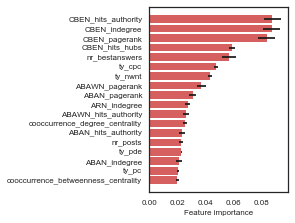

In [21]:
# top 10 feature importances

limit = 18

fig = plt.figure(figsize=(4, 3))
ax1 = fig.add_subplot(111)

ax1.barh([record[0] for record in enumerate(f_importance[:limit])],
        [record[1] for record in f_importance[:limit]], 
        color="r", 
        align="center",
        xerr=[record[2] for record in f_importance[:limit]])
ax1.invert_yaxis()
plt.yticks(range(limit), 
           [record[1][0] for record in enumerate(f_importance[:limit])],
           rotation=0)

plt.xlabel('Feature importance', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout(pad=0.3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'feats_importance_top' + plot_format)

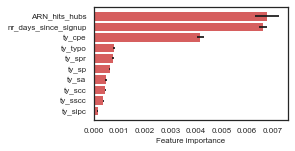

In [18]:
# least 10 feature importances

limit = 10

fig = plt.figure(figsize=(4, 2))
ax1 = fig.add_subplot(111)

ax1.barh( [record[0] for record in enumerate(f_importance[-limit:])],
        [record[1] for record in f_importance[-limit:]], 
        
        color="r", 
        align="center",
        xerr=[record[2] for record in f_importance[-limit:]])
ax1.invert_yaxis()
plt.yticks(range(limit), 
           [record[1][0] for record in enumerate(f_importance[-limit:])],
           rotation=0)

plt.xlabel('Feature importance', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout(pad=0.3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'feats_importance_least' + plot_format)

In [13]:
# print all in a Latex table

print pd.DataFrame.from_records(f_importance, columns=['Feature', 'Importance (Mean)', 'SD']).to_latex()

\begin{tabular}{llrr}
\toprule
{} &                              Feature &  Importance (Mean) &        SD \\
\midrule
0  &                  CBEN\_hits\_authority &           0.087901 &  0.006355 \\
1  &                        CBEN\_indegree &           0.087195 &  0.006210 \\
2  &                        CBEN\_pagerank &           0.083704 &  0.006189 \\
3  &                       CBEN\_hits\_hubs &           0.059041 &  0.001942 \\
4  &                       nr\_bestanswers &           0.056794 &  0.005245 \\
5  &                               ty\_cpc &           0.047544 &  0.001420 \\
6  &                              ty\_nwnt &           0.043544 &  0.001338 \\
7  &                       ABAWN\_pagerank &           0.037206 &  0.003124 \\
8  &                        ABAN\_pagerank &           0.030865 &  0.002759 \\
9  &                         ARN\_indegree &           0.027335 &  0.001544 \\
10 &                 ABAWN\_hits\_authority &           0.026217 &  0.002366 \\
11 &      

## Confusion Matrix

Confusion matrix, without normalization
[[1787  293]
 [ 521  448]]
Confusion matrix, without normalization
[[1787  293]
 [ 521  448]]
Confusion matrix, without normalization
[[1886  194]
 [ 670  299]]
Confusion matrix, without normalization
[[1905  175]
 [ 714  255]]
Confusion matrix, without normalization
[[1870  210]
 [ 677  292]]


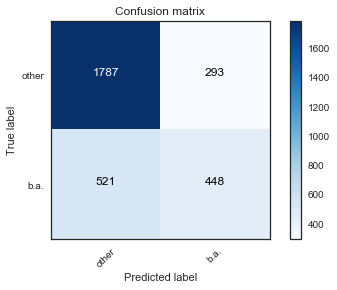

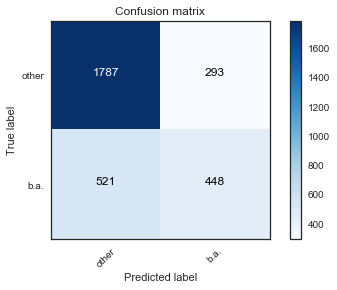

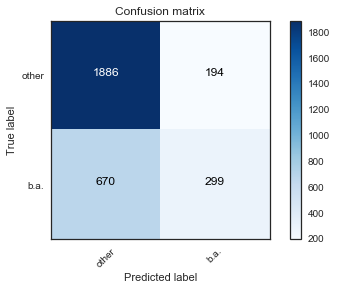

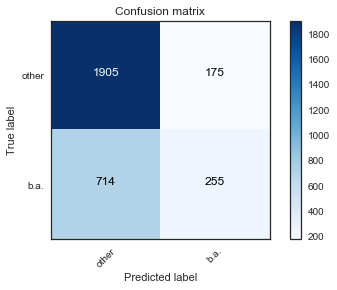

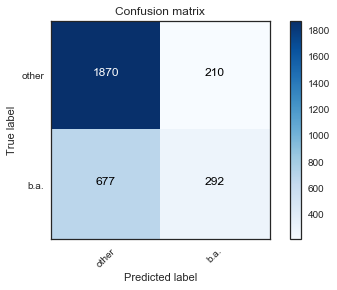

In [13]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
for file_name in files:
    plt.figure()
    plot_confusion_matrix(confusion_matrix_dict[file_name], ['other', 'b.a.'])

## GridSearchCV analysis

In [ ]:
# TODO

# Plots for post-processed predictions

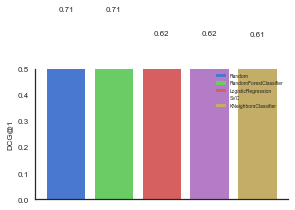

In [8]:
# plot DCG@1 bars

fig = plt.figure(figsize=(4, 2))
ax1 = fig.add_subplot(111)

labels = []
for idx, file_name in enumerate(files):
    labels.append(mean_dcg_data_post[file_name][0])
    rect = ax1.bar(idx,  
            mean_dcg_data_post[file_name][0],  
            label=file_name)
    
rects = ax1.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height + height*0.01, 
             np.round(label, decimals=2), 
             ha='center', 
             va='bottom',
            fontsize=8)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylim([0.0, 0.5])

plt.ylabel('DCG@1', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='x', bottom='off', labelbottom='off')

plt.grid(alpha=0.0, linestyle='dotted')
plt.legend(fontsize=5)
plt.tight_layout(pad=0.3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'dcg1_bars_post' + plot_format)

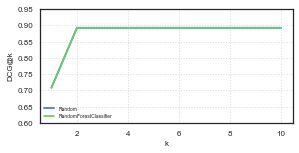

In [15]:
# plot NDCG curves

fig = plt.figure(figsize=(4, 2))
ax1 = fig.add_subplot(111)


for model_name in ['Random', 'RandomForestClassifier']:
    ax1.plot(range(1, 11), 
             mean_dcg_data_post[model_name], 
             label=model_name)
ax1.set_ylim([0.6, .95])

plt.xlabel('k', fontsize=8)
plt.ylabel('DCG@k', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)

plt.grid(alpha=0.7, linestyle='dotted')
plt.legend(fontsize=5)
plt.tight_layout(pad=0.3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'dcgK_lines_post' + plot_format)